# Wheat Market Analysis
## LSTM Notebook

### Matthew Garton - October 2018

**Purpose:** The purpose of this notebook is to try a neural network approach to recognizing patterns and predicting Wheat Futures Price data. I will attempt to build a LSTM model.

**Context**: The ultimate goal of my project is to develop a trading strategy for commodity futures, which will include both prediction modeling to identify price patterns and trading opportunities as well as a rules-based algorithm to make trading decisions and manage risk.

In [2]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

import math

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
wheat = pd.read_csv('../data/wheat_final_modeling.csv', index_col='Date', parse_dates=True)

## Data Preparation

To prepare the data for LSTM modeling, I first create windows so that I can use multiple steps of historical data to predict the next data point. The window size is a hyperparameter which can be tuned over to improve model performance.

In [4]:
def create_window(df, window_size = 1):    
    '''Return a dataframe with columns for each step in the window'''
    
    copy = df.copy()
    
    # for each row in the dataframe, add 'window size' columns,
    # each one representing the subsequent period's observation
    for i in range(window_size):
        df = pd.concat([df, copy.shift(-(i + 1))], 
                            axis = 1)
        
    df.dropna(axis=0, inplace=True)
    
    return df

There are a number of hyperparameters which can be tuned over in this framework. As an area for further refinement, I'd like to gridsearch over them to find the best possible model. For now, I'll instantiate all as variables in the cell below, and pass them as arguments into the model funtions. This will make it easier for me to manually tweak and tune the model.

In [5]:
# Model Parameters
window_size = 1
units = 25
activation = 'relu'
dropout = 0.2
epochs = 100
batch_size = 50
validation = 0.3

In [6]:
# Create dataset
wheat_window = create_window(wheat['2017']['Settle'], window_size = window_size)

# Create holdout set
test_window = create_window(wheat['2018'], window_size = window_size)

# X, y split - X is columns up to window size, y is the final observation in the window
X = wheat_window.iloc[:, 0:window_size]
y = wheat_window.iloc[:, window_size]

In [7]:
display(X.head(6))
display(y.head())

,Settle
Date,
2017-01-03,406.50
2017-01-04,418.50
2017-01-05,426.25
2017-01-06,423.25
2017-01-09,427.25
2017-01-10,426.75


Date
2017-01-03    418.50
2017-01-04    426.25
2017-01-05    423.25
2017-01-06    427.25
2017-01-09    426.75
Name: Settle, dtype: float64

In [8]:
# Reshape data to fit in the model
X = np.reshape(X.values, (X.shape[0], 1, X.shape[1]))

In [9]:
# Instantiate and fit the LSTM network
model = Sequential()

model.add(LSTM(input_shape=(X.shape[1], X.shape[2]), units=units, activation=activation))
model.add(Dropout(dropout))
model.add(Dense(1))
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')
history = model.fit(x=X, y=y.values, epochs=epochs, batch_size=batch_size, verbose=0, validation_split=validation)

In [9]:
# Save Training Loss and Validation Loss in a df
metrics = pd.DataFrame(history.history, columns=['val_loss', 'loss'])

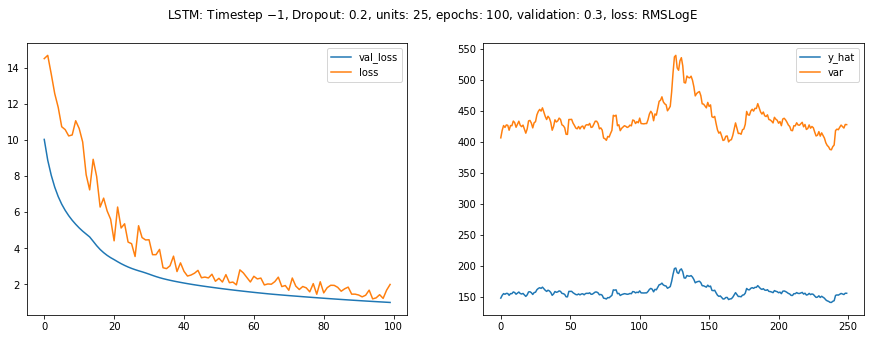

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.suptitle("LSTM: Timestep $-{}$, Dropout: {}, units: {}, epochs: {}, validation: {}, loss: RMSLogE".format(
    window_size, dropout, units, epochs, validation))

# Generate Predictions
y_hat = model.predict(X)

results = pd.DataFrame(list(zip(y_hat, X)), columns=["y_hat", "var"])
results['y_hat'] = results['y_hat'].map(lambda y_hat: y_hat[0])
results['var'] = results['var'].map(lambda var: var[0][0])
results.plot(ax=ax[1])
metrics.plot(ax=ax[0]);

## Observations

The model seems promising so far, although I am concerned about overfitting. Additionally, I think predicting forward one point is of limited value, so I need to work on predicting further out. 